In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pred123.csv to pred123.csv


In [ ]:
# 1. Import Libraries
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                           precision_recall_curve, roc_auc_score)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visual style
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)


In [ ]:
# 2. Data Loading and Initial Inspection
df = pd.read_csv('pred123.csv')
# Initial inspection
print("Dataset shape:", df.shape)
print("\nFirst 3 rows:")
display(df.head(3))
print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (230, 19)

First 3 rows:


,Timestamp,Age,Gender,What is your height?,What is your weight?,How many servings of fruits and vegetables do you consume per day?,How often do you consume fast food?,How much water do you drink daily?(in liters),How many days per week do you engage in moderate to intense exercise?,"On average, how many minutes do you exercise per session?",How many hours of sleep do you get on average per night?,Do you feel well-rested after sleep?,"On a scale of 1 to 10, how would you rate your stress levels?","How many hours per day do you spend on screens (e.g., TV, computer, phone)?",Do you smoke?,Do you consume alcohol?,What is your blood pressure category?,Have you been diagnosed with hypertension (high blood pressure)?,Do you have a family history of hypertension?
0,2025/02/18 6:52:34 pm GMT+5:30,23,Female,5.2,47,2,Frequently,2,2,30.0,6,No,7,6,Never,No,Normal: <120 / <80,Not sure,Yes
1,2025/02/18 6:52:50 pm GMT+5:30,21,Male,5.6,68,1,Frequently,3,2,45.0,7,Yes,4,5,Never,No,Elevated: 120-129 / <80,No,Yes
2,2025/02/18 7:01:10 pm GMT+5:30,25,Male,5.6,74,3,Frequently,2,7,1.0,7,Yes,5,7,Never,No,Normal: <120 / <80,No,No



Missing values:
Timestamp                                                                      0
Age                                                                            0
Gender                                                                         0
What is your height?                                                           0
What is your weight?                                                           0
How many servings of fruits and vegetables do you consume per day?             0
How often do you consume fast food?                                            0
How much water do you drink daily?(in liters)                                  0
How many days per week do you engage in moderate to intense exercise?          0
On average, how many minutes do you exercise per session?                      0
How many hours of sleep do you get on average per night?                       0
Do you feel well-rested after sleep?                                           0
On a scale 

In [ ]:
# 3. Data Preprocessing
# Clean height data (convert feet to cm)
df['Height_cm'] = df['What is your height?'].apply(lambda x: x*30.48 if x < 10 else x)
df.loc[df['Height_cm'] > 250, 'Height_cm'] = np.nan  # Remove outliers

# Calculate BMI
df['BMI'] = df['What is your weight?'] / ((df['Height_cm']/100) ** 2)

# Create BP categories
conditions = [
    (df['What is your blood pressure category?'].str.contains('Normal')),
    (df['What is your blood pressure category?'].str.contains('Elevated')),
    (df['What is your blood pressure category?'].str.contains('Stage 1')),
    (df['What is your blood pressure category?'].str.contains('Stage 2'))
]
choices = [0, 1, 2, 3]  # 0=Normal, 1=Elevated, 2=Stage1, 3=Stage2
df['BP_Class'] = np.select(conditions, choices, default=np.nan)
# Select and rename key features
features = {
    'Age': 'Age',
    'BMI': 'BMI',
    'How many hours of sleep do you get on average per night?': 'Sleep_hours',
    'On a scale of 1 to 10, how would you rate your stress levels?': 'Stress',
    'On average, how many minutes do you exercise per session?': 'Exercise_mins',
    'How many servings of fruits and vegetables do you consume per day?': 'Fruit_Veg',
    'Do you have a family history of hypertension?': 'Family_History'
}
df = df.rename(columns=features)[list(features.values()) + ['BP_Class']]
# Convert categorical to numerical
df['Family_History'] = df['Family_History'].map({'Yes':1, 'No':0})
# Drop remaining missing values
df = df.dropna()
print("\nCleaned data shape:", df.shape)


Cleaned data shape: (215, 8)


In [ ]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# Apply to numerical columns that might have outliers
numerical_cols = ['BMI', 'Sleep_hours', 'Stress', 'Exercise_mins', 'Fruit_Veg', 'Age']
for col in numerical_cols:
    df = remove_outliers_iqr(df, col)

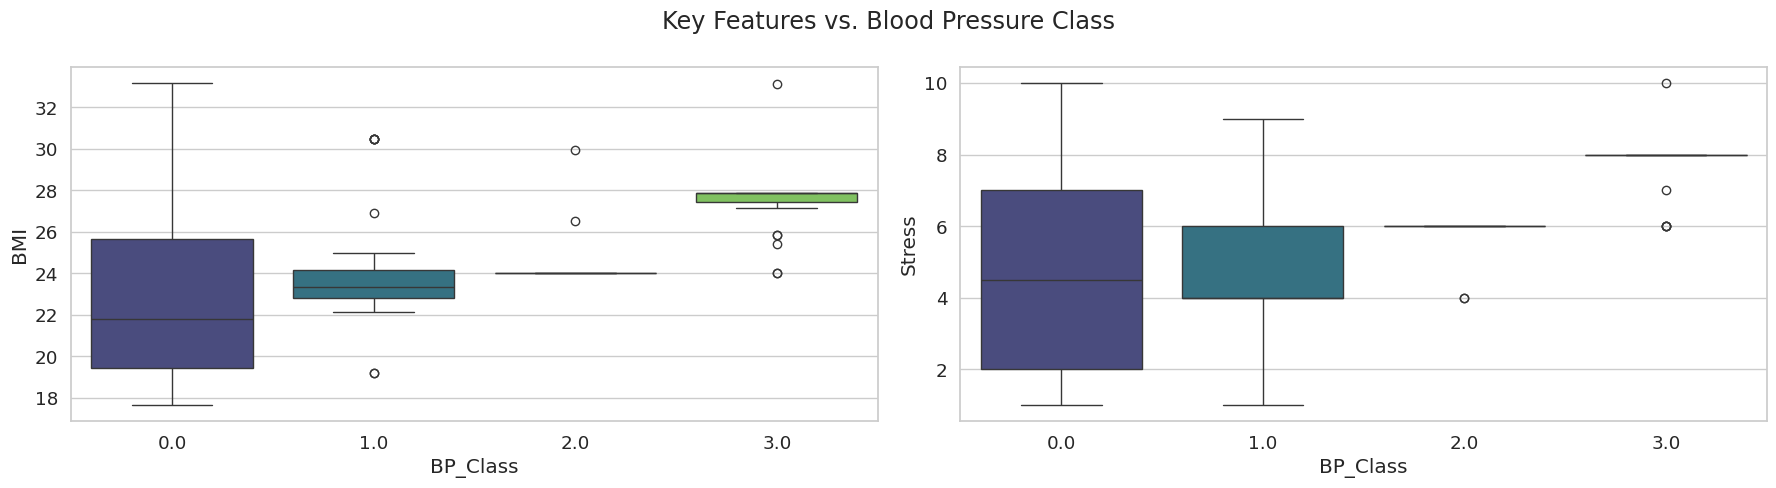

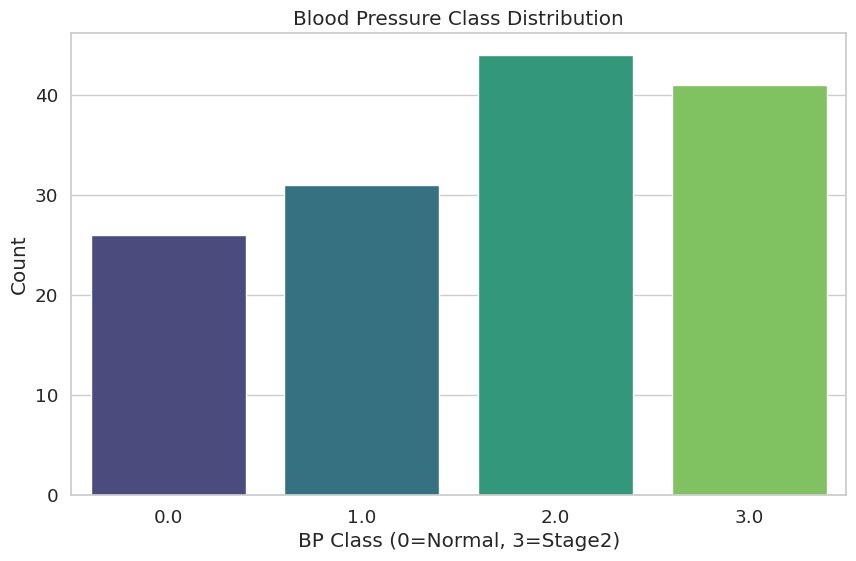

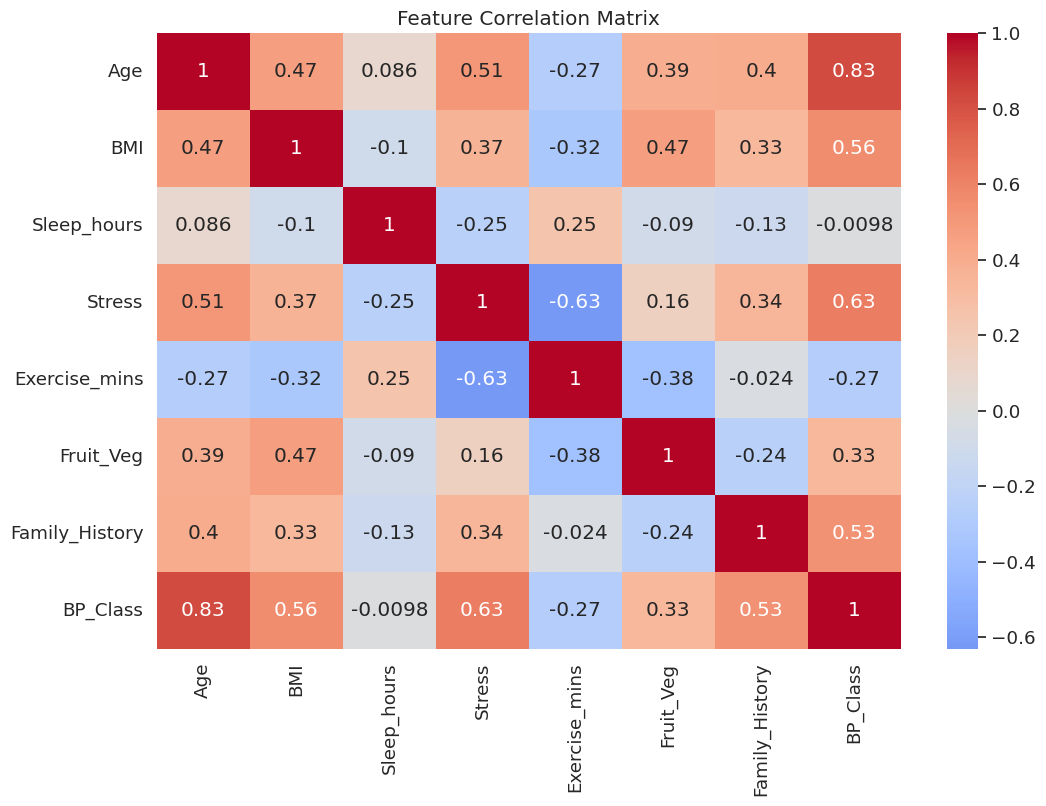

In [ ]:
# 4. Exploratory Data Analysis
# Visualize feature relationships
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(x='BP_Class', y='BMI', data=df, ax=ax[0], palette='viridis')
sns.boxplot(x='BP_Class', y='Stress', data=df, ax=ax[1], palette='viridis')
fig.suptitle('Key Features vs. Blood Pressure Class')
plt.tight_layout()
plt.show()
# Class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='BP_Class', data=df, palette='viridis')
plt.title('Blood Pressure Class Distribution')
plt.xlabel('BP Class (0=Normal, 3=Stage2)')
plt.ylabel('Count')
plt.show()
# Correlation matrix
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# 5. Feature Engineering
# ======================
# Create composite features
df['Lifestyle_Score'] = (
    0.4 * df['Exercise_mins']/60 +
    0.3 * df['Fruit_Veg']/5 +
    0.2 * (10 - df['Stress'])/10
)

# Add interaction feature
df['BMI_Stress'] = df['BMI'] * df['Stress']
df['Meets_Exercise_Guidelines'] = (df['Exercise_mins'] >= 30).astype(int)  # WHO standard
df['Exercise_Intensity'] = df['Exercise_mins'] * df['Stress']  # Interaction
# Standardize numerical features
scaler = StandardScaler()
num_features = ['Age', 'BMI', 'Sleep_hours', 'Stress',
               'Lifestyle_Score', 'BMI_Stress', 'Exercise_Intensity']
df[num_features] = scaler.fit_transform(df[num_features])


In [ ]:
# 6. Train-Test Split
# ======================
X = df.drop('BP_Class', axis=1)
y = df['BP_Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))




Class distribution in training set:
BP_Class
2.0    0.313131
3.0    0.282828
1.0    0.222222
0.0    0.181818
Name: proportion, dtype: float64


Original class distribution:
BP_Class
2.0    31
3.0    28
1.0    22
0.0    18
Name: count, dtype: int64

Resampled class distribution:
BP_Class
1.0    31
0.0    31
2.0    31
3.0    31
Name: count, dtype: int64


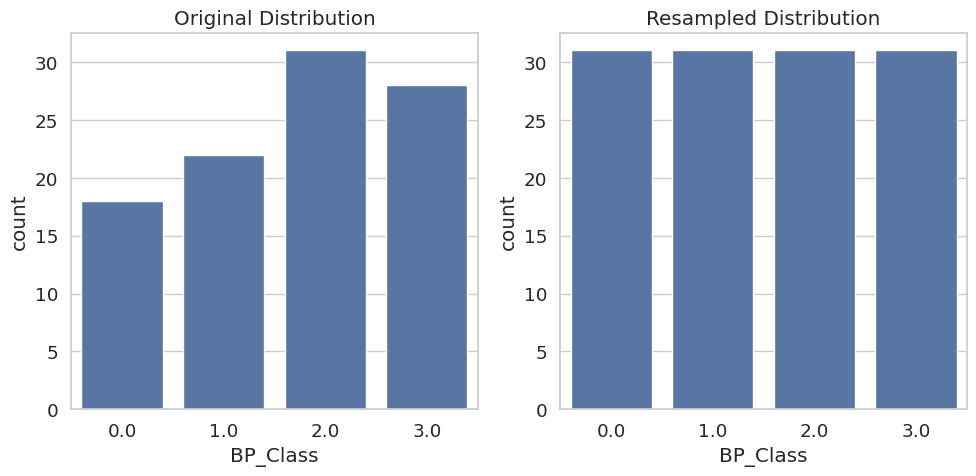

In [ ]:
# ======================
# 7. Handling Class Imbalance
# ======================
# Check original distribution
original_counts = y_train.value_counts()
print("Original class distribution:")
print(original_counts)

# Set target sizes for SMOTE
majority_size = max(original_counts)
sampling_strategy = {}
for cls, count in original_counts.items():
    if count >= 6:  # At least 6 samples for k_neighbors=5
        sampling_strategy[cls] = majority_size

# Apply SMOTE
smote = SMOTE(
    sampling_strategy=sampling_strategy,
    random_state=42,
    k_neighbors=5
)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Verify results
print("\nResampled class distribution:")
print(pd.Series(y_res).value_counts())

# Visual confirmation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x=y_res)
plt.title('Resampled Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# 8. Model Building
# ======================
# Base models
estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    )),
    ('svm', SVC(
        kernel='rbf',
        C=10,
        probability=True,
        class_weight='balanced',
        random_state=42
    ))
]

# Stacking classifier
model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(
            class_weight='balanced',
            max_iter=1000
        ),
        stack_method='predict_proba',
        n_jobs=-1
    ))
])

# Train model
model.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('stack',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=10,
                                                                        n_estimators=300,
                                                                        random_state=42)),
                                                ('svm',
                                                 SVC(C=10,
                                                     class_weight='balanced',
                                                     probability=True,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000),
                                    n_jobs=-1, stack_method='predict_proba'))])

In [ ]:
class_names = ['Normal', 'Elevated', 'Stage1', 'Stage2'] # Define class_names
from sklearn.metrics import accuracy_score


# Get the individual estimators from your stacking model
# Assuming your stacking model is named 'model' and was defined like:
# model = StackingClassifier(estimators=[...], final_estimator=...)

# # Get base estimators
# rf_model = model.named_estimators_['random_forest']
# svm_model = model.named_estimators_['svm']
# final_model = model.final_estimator_
rf_model = model.named_steps['stack'].estimators_[0]  # Access from StackingClassifier within Pipeline
svm_model = model.named_steps['stack'].estimators_[1]  # Access from StackingClassifier within Pipeline
final_model = model.named_steps['stack'].final_estimator_  # Access from StackingClassifier within Pipeline

# Make predictions with each model
rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)

# For the final estimator, we need to get the meta-features
meta_features = model.transform(X_test)
final_pred = final_model.predict(meta_features)

# Evaluate each model
print("\n=== Individual Model Performance ===")
print("\nRandom Forest:")
print(classification_report(y_test, rf_pred, digits=3, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.3f}")

print("\nSVM:")
print(classification_report(y_test, svm_pred, digits=3, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.3f}")

print("\nFinal Estimator (using meta-features):")
print(classification_report(y_test, final_pred, digits=3, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_test, final_pred):.3f}")

# Compare with the stacked model's performance
print("\nStacked Model Performance:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")


=== Individual Model Performance ===

Random Forest:
              precision    recall  f1-score   support

      Normal      0.889     1.000     0.941         8
    Elevated      1.000     1.000     1.000         9
      Stage1      1.000     0.923     0.960        13
      Stage2      1.000     1.000     1.000        13

    accuracy                          0.977        43
   macro avg      0.972     0.981     0.975        43
weighted avg      0.979     0.977     0.977        43

Accuracy: 0.977

SVM:
              precision    recall  f1-score   support

      Normal      0.429     0.375     0.400         8
    Elevated      0.375     0.333     0.353         9
      Stage1      1.000     0.923     0.960        13
      Stage2      0.812     1.000     0.897        13

    accuracy                          0.721        43
   macro avg      0.654     0.658     0.652        43
weighted avg      0.706     0.721     0.710        43

Accuracy: 0.721

Final Estimator (using meta-features)

In [ ]:
print("\n=== Cross-Validation Scores ===")

# Random Forest CV
rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {np.mean(rf_cv):.2f} ± {np.std(rf_cv):.2f}")

# SVM CV
svm_cv = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print(f"SVM CV Accuracy: {np.mean(svm_cv):.2f} ± {np.std(svm_cv):.2f}")

# Final estimator CV (need to create pipeline to transform data first)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Create a pipeline that mimics the stacking transformation
stack_transform = model.named_steps['stack']
stack_pipeline = make_pipeline(stack_transform, final_model)
cv_scores_final = cross_val_score(stack_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Final Estimator CV Accuracy: {np.mean(cv_scores_final):.2f} ± {np.std(cv_scores_final):.2f}")


=== Cross-Validation Scores ===
Random Forest CV Accuracy: 0.94 ± 0.06
SVM CV Accuracy: 0.78 ± 0.06
Final Estimator CV Accuracy: 0.92 ± 0.07


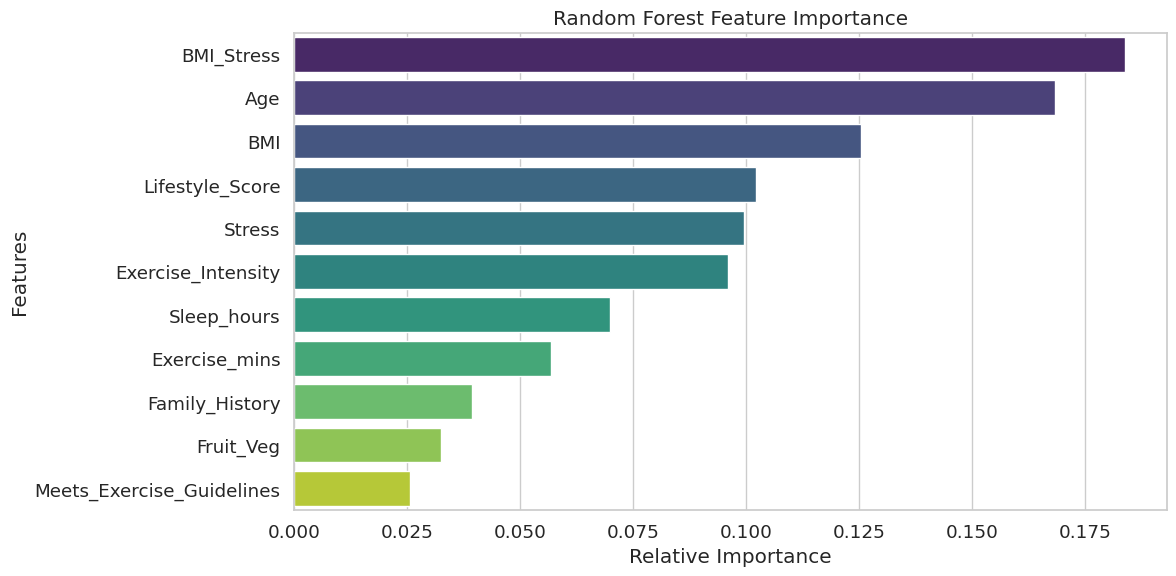

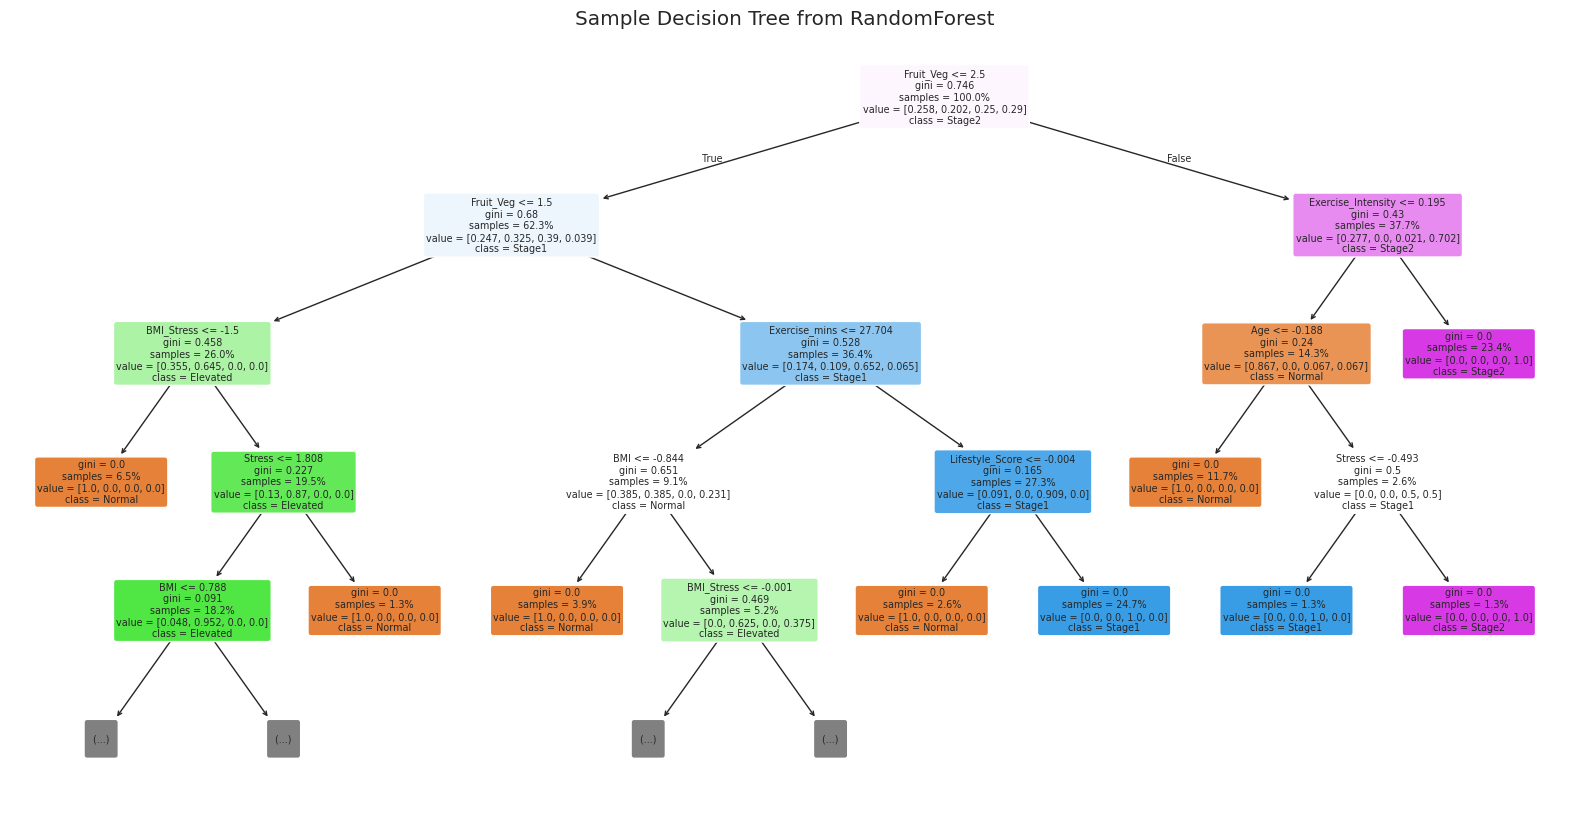

In [ ]:
# 10. Feature Importance Analysis
# ======================
# Extract the RandomForest estimator from the pipeline
rf_model = model.named_steps['stack'].estimators_[0]

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Plot sample decision tree
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=feature_names,
          class_names=['Normal','Elevated','Stage1','Stage2'],
          filled=True,
          max_depth=4,
          proportion=True,
          rounded=True)
plt.title('Sample Decision Tree from RandomForest')
plt.show()


In [ ]:
# ======================
# 12. Enhanced Clinical Prediction System
# ======================
def clinical_prediction_system(new_patient_data):
    """
    Enhanced clinical decision support with:
    - Critical alert overrides
    - Medical interpretation
    - Risk-stratified pathways
    """
    optimal_threshold = 0.7
    # 1. Data Preparation
    new_df = pd.DataFrame([new_patient_data])[X_train.columns]
    new_df[num_features] = scaler.transform(new_df[num_features])
    new_df['Family_History'] = new_df['Family_History'].astype(int)

    # 2. Model Prediction
    pred_prob = model.predict_proba(new_df)[0]
    pred_class = np.argmax(pred_prob)
    bp_classes = ['Normal', 'Elevated', 'Stage1', 'Stage2']

    # 3. Critical Alert Check
    print("\n=== AI Clinical Prediction Report ===")
    if pred_prob[3] >= optimal_threshold:
        print(f"🛑 CRITICAL ALERT: Stage2 Hypertension Probability ({pred_prob[3]:.1%})")
        print("\n[ACTION REQUIRED]")
        print("1. Immediate BP recheck (3 readings, 2min apart)")
        print("2. ECG and renal function tests")
        print("3. Initiate antihypertensive protocol if confirmed")

    # 4. Medical Interpretation
    print("\n=== Clinical Context ===")
    print(f"Top Prediction: {bp_classes[pred_class]} ({pred_prob[pred_class]:.1%})")
    if pred_prob[3] > 0.3:
        print("\nDifferential Diagnosis:")
        print(f"- Primary hypertension ({pred_prob[3]:.1%})")
        print(f"- White coat effect ({min(pred_prob[0]+pred_prob[1], 0.3):.1%} combined)")
        print(f"- Secondary causes ({pred_prob[2]:.1%})")

    # 5. Risk-Stratified Pathway
    print("\n=== Recommended Pathway ===")
    if pred_prob[3] >= 0.7:
        print("🚨 RED PATHWAY: Immediate specialist referral")
    elif pred_prob[3] >= 0.5:
        print("⚠️ URGENT: Next-day hypertension clinic")
    elif pred_prob[3] >= 0.3:
        print("🔔 PRIORITY: Primary care follow-up <72h")
    else:
        print("📅 ROUTINE: Next scheduled visit")

    # 6. Probability Breakdown
    print("\n=== Probability Breakdown ===")
    for i, prob in enumerate(pred_prob):
        print(f"{bp_classes[i]}: {prob:.1%}")

# Example Usage
new_patient = {
    'Age': 52,
    'BMI': 31.2,
    'Sleep_hours': 5,
    'Stress': 8,
    'Exercise_mins': 20,
    'Fruit_Veg': 1,
    'Family_History': 1,
    'Lifestyle_Score': 0.4,
    'BMI_Stress': 31.2 * 8,
    'Meets_Exercise_Guidelines': 0,
    'Exercise_Intensity': 20 * 8
}

clinical_prediction_system(new_patient)


=== AI Clinical Prediction Report ===
🛑 CRITICAL ALERT: Stage2 Hypertension Probability (72.8%)

[ACTION REQUIRED]
1. Immediate BP recheck (3 readings, 2min apart)
2. ECG and renal function tests
3. Initiate antihypertensive protocol if confirmed

=== Clinical Context ===
Top Prediction: Stage2 (72.8%)

Differential Diagnosis:
- Primary hypertension (72.8%)
- White coat effect (21.6% combined)
- Secondary causes (5.6%)

=== Recommended Pathway ===
🚨 RED PATHWAY: Immediate specialist referral

=== Probability Breakdown ===
Normal: 7.6%
Elevated: 14.0%
Stage1: 5.6%
Stage2: 72.8%


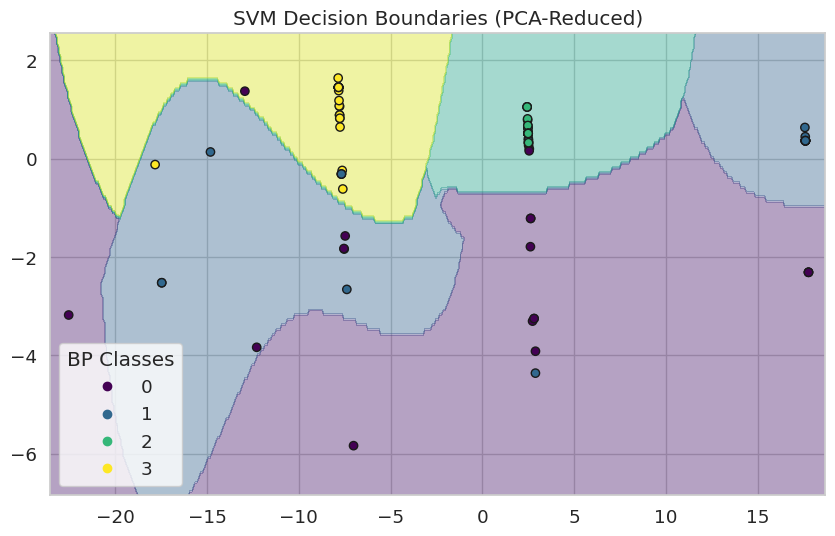

In [ ]:
# 13. SVM Visualization (Optional)
# ======================
# PCA reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Train SVM on reduced data
svm_viz = SVC(kernel='rbf', C=10, probability=True)
svm_viz.fit(X_pca, y_train)

# Create decision boundary plot
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='viridis', edgecolor='k')
plt.legend(*scatter.legend_elements(), title='BP Classes')
plt.title('SVM Decision Boundaries (PCA-Reduced)')
plt.show()


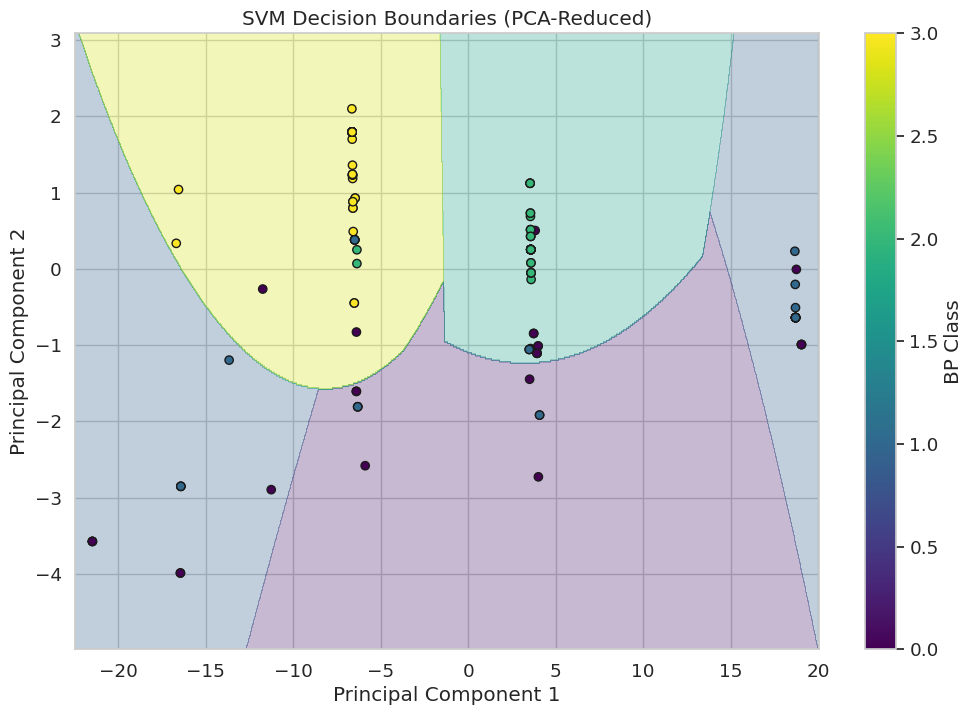

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 2. Create Meshgrid for Decision Boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 3. Predict on Grid Points
Z = svm_model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# 4. Plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundaries (PCA-Reduced)')
plt.colorbar(label='BP Class')
plt.show()

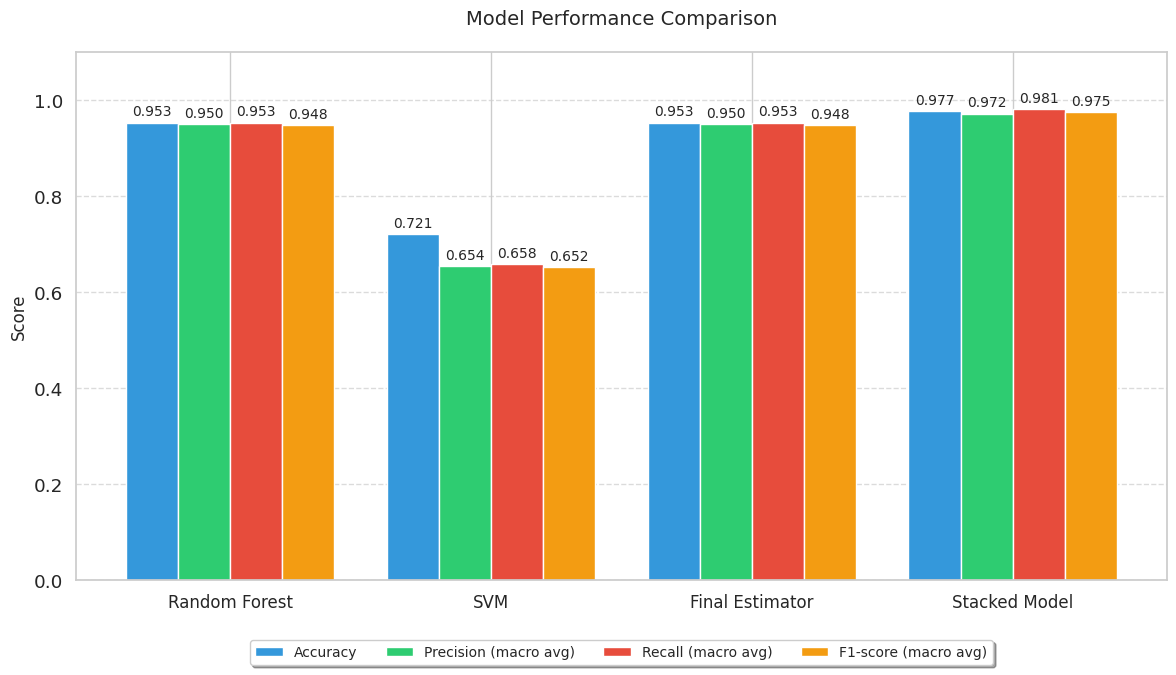

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data from your results
models = ['Random Forest', 'SVM', 'Final Estimator', 'Stacked Model']
accuracy = [0.953, 0.721, 0.953, 0.977]
precision = [0.950, 0.654, 0.950, 0.972]  # Macro avg precision
recall = [0.953, 0.658, 0.953, 0.981]     # Macro avg recall
f1 = [0.948, 0.652, 0.948, 0.975]         # Macro avg F1-score

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))

# Create bars for each metric
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color='#3498db')
rects2 = ax.bar(x - width/2, precision, width, label='Precision (macro avg)', color='#2ecc71')
rects3 = ax.bar(x + width/2, recall, width, label='Recall (macro avg)', color='#e74c3c')
rects4 = ax.bar(x + width*1.5, f1, width, label='F1-score (macro avg)', color='#f39c12')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0, 1.1)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize=10)

plt.tight_layout()
plt.show()